# Setting up the Notebook

KBMOD uses Python's logging library for output during the run. If you are interested in running with debug output (verbose mode), you can set the level of Python's logger to `WARNING` (for warning messages only), `INFO` (for moderate output), or `DEBUG` (for comprehensive output). By default logging is set to warning level.

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

# Load the data.

We load the data using the `ImageCollection` class to load all the FITS files in the given directory.

`KBMODV0_5Config` provides some parameters about how to read the files. The important ones for this investiation are the ones involved with masking:

* bit_flag_map is a dictionary from masking reason to the bit set in the mask layer, such as: `{ "BAD": 2**0, "EDGE": 2**4, "NO_DATA": 2**8, "UNMASKEDNAN": 2**15 }`
* mask_flags is a list of which reasons to mask such as `["BAD", "UNMASKEDNAN"]`
    
The combination of those two flags will mask all pixels with the 1st and/or 15th bits set in the mask layer.

Below we are not masking anything because I don't know which bits correspond to which flags for this survery.

In [11]:
filepath = "./kbmod_fits_example"

from kbmod.image_collection import ImageCollection
from kbmod.standardizers.fits_standardizers.kbmodv05 import KBMODV0_5, KBMODV0_5Config

ps1_bit_flag_map = {
    "DETECTOR": 2**0,
    "FLAT": 2**1,
    "DARK": 2**2,
    "BLANK": 2**3,
    "CTE": 2**4,
    "SAT": 2**5,
    "LOW": 2**6,
    "SUSPECT": 2**7,
    "BURNTOOL": 2**8,
    "CR": 2**9,
    "SPIKE": 2**10,
    "GHOST": 2**11,
    "STREAK": 2**12,
    "STARCORE": 2**13,
    "CONV.BAD": 2**14,
    "CONV.POOR": 2**15,
    "MARK": 2**16
}

ps1_mask_flags = ["DETECTOR", "BLANK", "CR", 
                  "SPIKE", "GHOST", "STARCORE",
                  "CONV.BAD", "STREAK", "BURNTOOL"]

load_config = KBMODV0_5Config(mask_flags=ps1_mask_flags, bit_flag_map=ps1_bit_flag_map)

# Loading from the files takes a while (multiple minutes).
ic = ImageCollection.fromDir(filepath, force=KBMODV0_5, config=load_config)
wu = ic.toWorkUnit()
wu.print_stats()

INFO:kbmod.image_collection:Creating ImageCollection from 29 standardizers.
INFO:kbmod.image_collection:Building WorkUnit from ImageCollection


WorkUnit:
  Num Constituent Images (29):
  Reprojected: False
Image Stack Statistics:
  Image Count: 29
  Image Size: 6295 x 6261 = 39412995
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|  idx |     Time   |  Flux Min  |  Flux Max  |  Flux Mean |  Var Min |  Var Max | Var Mean | Masked |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    0 |  56793.445 |    -148.94 |   23410.41 |       1.04 |     0.00 |     0.01 |     0.00 |  26.07 |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    1 |  56759.553 |    -152.22 |   30344.73 |       1.05 |     0.00 |     0.01 |     0.01 |  28.21 |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    2 |  55340.340 |    -174.64 |   13124.54 |       3.99 |     0.00 |     0.01 |     0.00 |  62.08 |
+------+------------+------------+-

If you want to modify the images directly, you can use the `im_stack` attribute in the WorkUnit.  For example, we could use built-in `ImageStack` functions to mask out science pixels that too bright or negative variance pixels.

In [12]:
wu.im_stack.mask_by_science_bounds(max_val=20.0, min_val=0.0)
# wu.im_stack.mask_by_variance_bounds(min_val=1e-10)

wu.print_stats()

WorkUnit:
  Num Constituent Images (29):
  Reprojected: False
Image Stack Statistics:
  Image Count: 29
  Image Size: 6295 x 6261 = 39412995
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|  idx |     Time   |  Flux Min  |  Flux Max  |  Flux Mean |  Var Min |  Var Max | Var Mean | Masked |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    0 |  56793.445 |       0.17 |      19.92 |       8.68 |     0.00 |     0.01 |     0.00 |  69.67 |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    1 |  56759.553 |       1.05 |      16.38 |       7.53 |     0.00 |     0.01 |     0.01 |  68.92 |
+------+------------+------------+------------+------------+----------+----------+----------+--------+
|    2 |  55340.340 |       0.43 |      19.02 |       8.59 |     0.00 |     0.01 |     0.00 |  85.39 |
+------+------------+------------+-

We could even plot the first image. The image stack contains lists of images `sci` for science and `var` for variance. So we would access the first science image as `wu.im_stack.sci[0]`

(<Figure size 640x480 with 2 Axes>, <Axes: >)

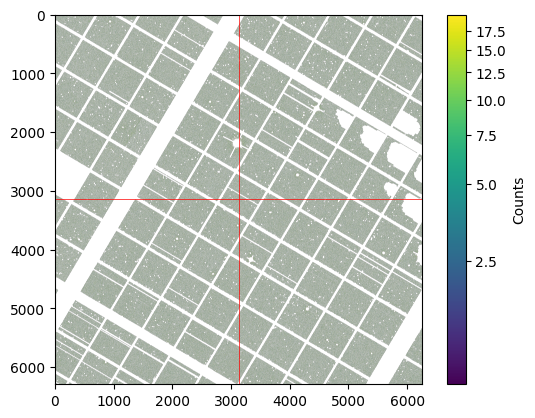

In [13]:
from kbmod.analysis.plotting import plot_image

plot_image(wu.im_stack.sci[0], norm=True)

# Set up the KBMOD Search

The standard approach to running KBMOD is to perform a grid search over all starting pixels and a grid of velocities. Let’s do a grid search with:
* 21 different velocity steps from -2 pixels per day and 2 pixels per day in the x dimension
* 21 different velocity steps from -2 pixels per day and 2 pixels per day in the y dimension

KBMOD needs a series of configuration parameters to specify all the information about the search. For the full list of parameters see:

https://epyc.astro.washington.edu/~kbmod/user_manual/search_params.html

In this notebook we explicitly provide the configuration parameters as a dictionary so users can see what is being specified. However most users will want to use the `SearchConfiguration` class. A `SearchConfiguration` object uses reasonable defaults when created:

In [76]:
from kbmod.configuration import SearchConfiguration

input_parameters = {
    # Use search parameters (including a force ecliptic angle of 0.0)
    # to match what we know is in the demo data.
    "generator_config": {
        "name": "VelocityGridSearch",
        "vx_steps": 21,
        "min_vx": -2.0,
        "max_vx": 2.0,
        "vy_steps": 21,
        "min_vy": -2.0,
        "max_vy": 2.0,
    },
    # Output parameters
    "result_filename": "./results.ecsv",
    # Basic filtering (always applied)
    "num_obs": 15,  # <-- Filter anything with fewer than 15 observations
    "lh_level": 10.0,  # <-- Filter anything with a likelihood < 10.0
    # SigmaG clipping parameters
    "sigmaG_lims": [25, 75],  # <-- Clipping parameters (lower and upper percentile)
    # Other parameters
    "cpu_only": True,  # <-- This will be absurdly slow.  Set to False if you have a good enough GPU.
}
config = SearchConfiguration.from_dict(input_parameters)

# Make the WorkUnit use this configuration.
wu.config = config

In [33]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table
from astropy.wcs.utils import skycoord_to_pixel


## More Limited Search

Before doing a full search across the images, I would suggest starting with a very limited search around the known object's position and velocity.  Something like:

In [98]:
ra = 228.7472256453729 * u.deg
dec = 48.8013123316322 * u.deg
pmra = -938.043889 * u.mas / u.yr
pmdec = 1464.629578 * u.mas / u.yr
pmra_cos_dec = pmra * np.cos(dec.to(u.rad))
ref_epoch = Time("J2000")
hpms_coords = SkyCoord(ra=ra, dec=dec, 
                       pm_ra_cosdec=pmra_cos_dec, pm_dec=pmdec, 
                       frame='icrs', obstime=ref_epoch)

img_path = Path("./kbmod_fits_example/rings.v3.skycell.2327.023.wrp.i.54985_42884.combined.fits")

with fits.open(img_path.open('rb')) as hdul:
    hdr = hdul[1].header
    wcs = WCS(hdr)
    
hpms_pixels = skycoord_to_pixel(hpms_coords, wcs)
print(f"Pixel Coords are: x={hpms_pixels[0]}, y={hpms_pixels[1]}, type={type(hpms_pixels[0])}")

t1 = ref_epoch + 1 * u.day
one_day_delta = hpms_coords.apply_space_motion(new_obstime=t1)
pixels_one_day_delta = skycoord_to_pixel(one_day_delta, wcs)

pm_pixels = np.array(pixels_one_day_delta) - np.array(hpms_pixels)

# Substitute known values here if you have them.
known_x0 = int(hpms_pixels[0])  # The object's x pixel coordinate at the first time.
known_y0 = int(hpms_pixels[1])  # The object's y pixel coordinate at the first time.
known_vx = (pm_pixels[0])  # The object's x velocity in pixels per day.
known_vy = (pm_pixels[1]) # The object's y velocity in pixels per day.
print(f"vx: {known_vx}, vy:{known_vy}")

input_parameters = {
    "x_pixel_bounds": [known_x0 - 1, known_x0 + 1],
    "y_pixel_bounds": [known_y0 - 1, known_y0 + 1],

    # Use search parameters (including a force ecliptic angle of 0.0)
    # to match what we know is in the demo data.
    "generator_config": {
        "name": "VelocityGridSearch",
        "vx_steps": 2,
        "min_vx": known_vx - 1,
        "max_vx": known_vx + 1,
        "vy_steps": 2,
        "min_vy": known_vy - 1,
        "max_vy": known_vy + 1,
    },
    # Output parameters
    "result_filename": "./results.ecsv",
    # Basic filtering (always applied)
    "num_obs": 15,  # <-- Filter anything with fewer than 15 observations
    "lh_level": 10.0,  # <-- Filter anything with a likelihood < 10.0
    # SigmaG clipping parameters
    "sigmaG_lims": [25, 75],  # <-- Clipping parameters (lower and upper percentile)
    # Other parameters
    "cpu_only": True,  # <-- This will be absurdly slow.  Set to False if you have a good enough GPU.
    "coadds": ["mean","median"],
    "save_all_stamps": True
}
config = SearchConfiguration.from_dict(input_parameters)

# Make the WorkUnit use this configuration.
wu.config = config

Pixel Coords are: x=4713.048891188855, y=454.6687334780654, type=<class 'numpy.ndarray'>
vx: 0.0069284296141631785, vy:0.015980131745891413


/Users/joaopassos/Software/HPMS_search/kbmod_env/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


# Running KBMOD

You run KBMOD by giving it a WorkUnit that contains the input image data and the configuration.

In [99]:
from kbmod.run_search import SearchRunner

rs = SearchRunner()
results = rs.run_search_from_work_unit(wu)

INFO:kbmod.trajectory_generator:Creating trajectory generator of type VelocityGridSearch
INFO:kbmod.search.psi_phi_array:Building 58 temporary 6295 by 6261 images, requiring 9143814840 bytes.
INFO:kbmod.search.run_search:Searching X=[4712, 4714] Y=[453, 455]
Allocating space for 32 results.
INFO:kbmod.run_search:Retrieving Results (total=4)
INFO:kbmod.run_search:Max Likelihood = 7.493678050393895e+31
INFO:kbmod.run_search:Min. Likelihood = 9.334864895906039e+26
INFO:kbmod.run_search:Prefiltering Near Duplicates (bin_width=10, max_dt=1808.0288256799977)
INFO:kbmod.run_search:After prefiltering 2 remaining.
INFO:kbmod.results:Applying filter=no valid observations to results of size 2.
INFO:kbmod.results:Applying filter=sigma-g to results of size 0.
INFO:kbmod.filters.stamp_filters:Appending all stamps for 0 results
INFO:kbmod.results:Saving column all_stamps to results_all_stamps.fits
INFO:kbmod.results:Writing all_stamps column data to results_all_stamps.fits
INFO:kbmod.results:Saving r

In [78]:
table = Table.read("results.ecsv", format='ascii.ecsv')
table

x,y,vx,vy,likelihood,flux,obs_count,uuid,psi_curve,phi_curve,obs_valid,coadd_sum,stamp,pred_x,pred_y,img_ra,img_dec,img_x,img_y
int64,int64,float64,float64,float64,float64,int64,str32,float32[29],float32[29],bool[29],"float32[21,21]","float32[21,21]",float64[29],float64[29],float64[29],float64[29],float64[29],float64[29]
5055,4900,1.0,-0.20000000298023224,2744.883544921875,144.9639129638672,18,e31651d57cf24378854e3ca414f6d5a3,2551.5208 .. 3681.9482,20.240562 .. 22.800915,True .. True,24.78125 .. 37.070312,24.78125 .. 37.070312,5055.5 .. 5055.48710251,4900.5 .. 4900.502579498038,228.7156161429008 .. 228.71561751344152,49.11015109215581 .. 49.1101512627752,5055.500000000011 .. 5055.487102509973,4900.4999999999145 .. 4900.502579498054
6026,5742,0.20000000298023224,-0.20000000298023224,2420.844482421875,131.00653076171875,16,bdca30f1e16c46ff8bb5c13d2f487327,2768.7222 .. 1685.5659,18.019915 .. 19.26159,True .. True,40.628906 .. 53.53125,40.628906 .. 53.53125,6026.5 .. 6026.497420501962,5742.5 .. 5742.502579498038,228.61336094374988 .. 228.61336121991937,49.169197555808815 .. 49.16919773344193,6026.500000000124 .. 6026.497420501823,5742.500000000218 .. 5742.502579497865
1106,6087,-1.0,1.399999976158142,2413.679931640625,135.97792053222656,15,9139c7c414ea44368ba0e8de01080e29,0.0 .. 3533.7644,0.0 .. 19.003208,False .. True,30.759766 .. 42.609375,30.759766 .. 42.609375,1106.5 .. 1106.51289749,6087.5 .. 6087.481943514307,229.13631849083637 .. 229.13631709179074,49.18920105577301 .. 49.18919981578909,1106.4999999999636 .. 1106.5128974900254,6087.499999999796 .. 6087.481943514391
6139,5090,1.7999999523162842,1.2000000476837158,2356.73291015625,132.48133850097656,15,f37317baa3994c19a3f83084228d78e0,0.0 .. 0.0,0.0 .. 0.0,False .. False,36.726562 .. 45.86133,36.726562 .. 45.86133,6139.5 .. 6139.476784518615,5090.5 .. 5090.484523011385,228.60080498754505 .. 228.60080743739283,49.12399524523853 .. 49.123994157977265,6139.49999999992 .. 6139.476784518704,5090.500000000107 .. 5090.48452301163
6189,2656,0.4000000059604645,1.0,2083.304443359375,130.0689239501953,15,8e6b4d4db8a9491b90017cf76d8038e6,0.0 .. 0.0,0.0 .. 0.0,False .. False,53.88086 .. 75.541016,53.88086 .. 75.541016,6189.5 .. 6189.494841003923,2656.5 .. 2656.48710251,228.59345122643913 .. 228.59345176107882,48.95505157926699 .. 48.955050681155775,6189.5000000000355 .. 6189.494841003826,2656.500000000233 .. 2656.4871025100656
5877,6219,1.7999999523162842,1.7999999523162842,1912.1146240234375,122.80360412597656,15,9322ef3400a74ed18e1bebd387ca5b87,1538.3085 .. 2510.5837,17.9907 .. 19.582916,True .. True,22.017578 .. 28.439453,22.017578 .. 28.439453,5877.5 .. 5877.476784518615,6219.5 .. 6219.476784518615,228.62960997309784 .. 228.62961241929327,49.20222898589915 .. 49.20222736071331,5877.500000000071 .. 5877.476784518628,6219.5000000001055 .. 6219.476784518751
6116,5035,1.399999976158142,0.0,2213.25244140625,127.5634536743164,15,bc1370f90bb74cd5983cf2e18e8280cf,0.0 .. 0.0,0.0 .. 0.0,False .. False,36.617188 .. 40.38867,36.617188 .. 40.38867,6116.5 .. 6116.481943514307,5035.5 .. 5035.5,228.60319810215373 .. 228.6032000176991,49.12016422128983 .. 49.12016421131031,6116.499999999919 .. 6116.481943514168,5035.500000000091 .. 5035.499999999989
6259,4193,1.399999976158142,0.800000011920929,1987.8067626953125,119.11688995361328,15,e6a9b2fb9ab0468db8b70588ec13c1c0,0.0 .. 0.0,0.0 .. 0.0,False .. False,79.16211 .. 103.49609,79.16211 .. 103.49609,6259.5 .. 6259.481943514307,4193.5 .. 4193.489682007847,228.58732626763222 .. 228.58732817231788,49.061787833187765 .. 49.061787107182035,6259.49999999996 .. 6259.481943514254,4193.500000000116 .. 4193.489682007621
6208,3389,1.600000023841858,0.0,2199.111328125,128.02389526367188,17,143c552d772546ecb194c3424d86cf8f,0.0 .. 0.0,0.0 .. 0.0,False .. False,50.740234 .. 23.720703,50.740234 .. 23.720703,6208.5 .. 6208.479364015693,3389.5 .. 3389.5,228.5920558539867 .. 228.59205803809067,49.00594581389126 .. 49.005945802716475,6208.500000000054 .. 6208.479364015798,3

In [85]:
# Sort by likelihood and see wether or not our star is the most likelihood.
sorted_table = table[np.argsort(table['likelihood'])[::-1]]
sorted_table

x,y,vx,vy,likelihood,flux,obs_count,uuid,psi_curve,phi_curve,obs_valid,coadd_sum,stamp,pred_x,pred_y,img_ra,img_dec,img_x,img_y
int64,int64,float64,float64,float64,float64,int64,str32,float32[29],float32[29],bool[29],"float32[21,21]","float32[21,21]",float64[29],float64[29],float64[29],float64[29],float64[29],float64[29]
5055,4900,1.0,-0.20000000298023224,2744.883544921875,144.9639129638672,18,e31651d57cf24378854e3ca414f6d5a3,2551.5208 .. 3681.9482,20.240562 .. 22.800915,True .. True,24.78125 .. 37.070312,24.78125 .. 37.070312,5055.5 .. 5055.48710251,4900.5 .. 4900.502579498038,228.7156161429008 .. 228.71561751344152,49.11015109215581 .. 49.1101512627752,5055.500000000011 .. 5055.487102509973,4900.4999999999145 .. 4900.502579498054
6026,5742,0.20000000298023224,-0.20000000298023224,2420.844482421875,131.00653076171875,16,bdca30f1e16c46ff8bb5c13d2f487327,2768.7222 .. 1685.5659,18.019915 .. 19.26159,True .. True,40.628906 .. 53.53125,40.628906 .. 53.53125,6026.5 .. 6026.497420501962,5742.5 .. 5742.502579498038,228.61336094374988 .. 228.61336121991937,49.169197555808815 .. 49.16919773344193,6026.500000000124 .. 6026.497420501823,5742.500000000218 .. 5742.502579497865
1106,6087,-1.0,1.399999976158142,2413.679931640625,135.97792053222656,15,9139c7c414ea44368ba0e8de01080e29,0.0 .. 3533.7644,0.0 .. 19.003208,False .. True,30.759766 .. 42.609375,30.759766 .. 42.609375,1106.5 .. 1106.51289749,6087.5 .. 6087.481943514307,229.13631849083637 .. 229.13631709179074,49.18920105577301 .. 49.18919981578909,1106.4999999999636 .. 1106.5128974900254,6087.499999999796 .. 6087.481943514391
6139,5090,1.7999999523162842,1.2000000476837158,2356.73291015625,132.48133850097656,15,f37317baa3994c19a3f83084228d78e0,0.0 .. 0.0,0.0 .. 0.0,False .. False,36.726562 .. 45.86133,36.726562 .. 45.86133,6139.5 .. 6139.476784518615,5090.5 .. 5090.484523011385,228.60080498754505 .. 228.60080743739283,49.12399524523853 .. 49.123994157977265,6139.49999999992 .. 6139.476784518704,5090.500000000107 .. 5090.48452301163
6116,5035,1.399999976158142,0.0,2213.25244140625,127.5634536743164,15,bc1370f90bb74cd5983cf2e18e8280cf,0.0 .. 0.0,0.0 .. 0.0,False .. False,36.617188 .. 40.38867,36.617188 .. 40.38867,6116.5 .. 6116.481943514307,5035.5 .. 5035.5,228.60319810215373 .. 228.6032000176991,49.12016422128983 .. 49.12016421131031,6116.499999999919 .. 6116.481943514168,5035.500000000091 .. 5035.499999999989
6208,3389,1.600000023841858,0.0,2199.111328125,128.02389526367188,17,143c552d772546ecb194c3424d86cf8f,0.0 .. 0.0,0.0 .. 0.0,False .. False,50.740234 .. 23.720703,50.740234 .. 23.720703,6208.5 .. 6208.479364015693,3389.5 .. 3389.5,228.5920558539867 .. 228.59205803809067,49.00594581389126 .. 49.005945802716475,6208.500000000054 .. 6208.479364015798,3389.4999999998836 .. 3389.5000000001455
6190,5181,1.600000023841858,1.7999999523162842,2159.666015625,129.62689208984375,15,d09685495b284a7dadeb22c891251a82,0.0 .. 0.0,0.0 .. 0.0,False .. False,70.58594 .. 25.61914,70.58594 .. 25.61914,6190.5 .. 6190.479364015693,5181.5 .. 5181.476784518615,228.59547102273257 .. 228.59547319277428,49.13034083250025 .. 49.130339209511625,6190.499999999906 .. 6190.479364015812,5181.5000000000055 .. 5181.476784518669
275,4696,-1.399999976158142,1.7999999523162842,2140.6337890625,124.61512756347656,15,8ebb849981f04dd191d25e7395d9d414,0.0 .. 0.0,0.0 .. 0.0,False .. False,98.91797 .. 32.345703,98.91797 .. 32.345703,275.5 .. 275.51805648569234,4696.5 .. 4696.476784518615,229.22216581747807 .. 229.22216386329575,49.091747984372034 .. 49.09174639316593,275.50000000008004 .. 275.5180564855109,4696.500000000027 .. 4696.4767845183815
3638,40,-0.4000000059604645,-2.0,2128.968017578125,119.81005859375,15,5c0dd36bc9974a599cec701ebb108ee3,2008.1067 .. 2567.0605,19.09888 .. 17.832424,True .. True,21.15625 .. 55.96289,21.15625 .. 55.96289,3638.5 .. 3638.5051589960767,40.5 .. 40.52579497999977,228.8599728919924 .. 228.8599723798477,48.77177925794498 .. 48.77178105228131,3638.5000000001473 .. 3638.5051589961167,40.5000000

<Figure size 640x480 with 0 Axes>

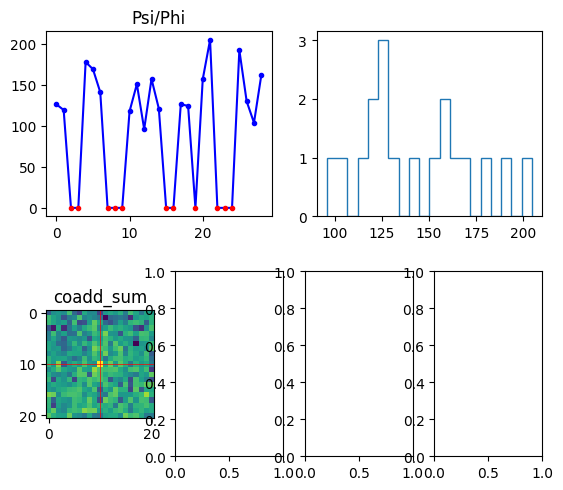

In [79]:
from kbmod.analysis.plotting import *
plot_result_row_summary(results[0])

In [82]:
# plot_multiple_images(results["all_stamps"][0], columns=5)
results.colnames

['x',
 'y',
 'vx',
 'vy',
 'likelihood',
 'flux',
 'obs_count',
 'uuid',
 'psi_curve',
 'phi_curve',
 'obs_valid',
 'coadd_sum',
 'stamp',
 'pred_x',
 'pred_y',
 'img_ra',
 'img_dec',
 'img_x',
 'img_y']